In [1]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import torch

In [2]:
Kernelxx = np.array([[[[-1./6., 1./3., -1./6.], [-2./3., 4./3., -2./3.], [-1./6., 1./3., -1./6.]]]])  # \partial_{xx}
Kernelxy = np.array([[[[-1./4., 0., 1./4.], [0., 0., 0.], [1./4., 0., -1./4.]]]])  # \partial_{xy}
Kernelyx = np.array([[[[-1./4., 0., 1./4.], [0., 0., 0.], [1./4., 0., -1./4.]]]])  # \partial_{yx}
Kernelyy = np.array([[[[-1./6., -2./3., -1./6.], [1./3., 4./3.,1./3.], [-1./6., -2./3., -1./6.]]]])  # \partial_{yx}

In [3]:
def CreateKernelA(epsilons, data_num=100, repeat=True):
    m = epsilons.shape[0]
    if repeat:
        KernelA = torch.zeros([m*data_num, 1, 3, 3], dtype=torch.float64)
        for i in range(m):
            K = epsilons[i, 0]*Kernelxx + \
                (epsilons[i, 1] + epsilons[i, 2]) * \
                Kernelxy + epsilons[i, 3]*Kernelyy
            for j in range(data_num):
                KernelA[i*data_num+j] = K
    else:
        KernelA = torch.zeros([m, 1, 3, 3], dtype=torch.float64)
        for i in range(m):
            KernelA[i] = epsilons[i, 0]*Kernelxx + \
                (epsilons[i, 1] + epsilons[i, 2]) * \
                Kernelxy + epsilons[i, 3]*Kernelyy

    return KernelA

In [4]:
def ComputeSmootherFactor(etas_train, N, w):
    KernelA  = CreateKernelA(etas_train, data_num=1, repeat=True)  
    device = KernelA.device
    h = 1/(N+1)
    p1 = range(-N//2, N//2)
    p2 = range(-N//2, N//2)
    P1, P2 = np.meshgrid(p1, p2)
    P1 = torch.from_numpy(P1)
    P2 = torch.from_numpy(P2)
    P1, P2 = P1.to(device), P2.to(device)
    theta1 = 2j*np.pi*P1*h
    theta2 = 2j*np.pi*P2*h
    Y = torch.ones([KernelA.shape[0], 1, N, N], device=device)
    for i in range(KernelA.shape[0]):
        k1, k2, k3, k4, k5, k6, k7, k8, k9 = KernelA[i].flatten()[:]
        taus = [w/KernelA[i, 0, 1, 1]]*5
        y = 1
        for j in range(len(taus)):
            y *= 1-taus[j] * (k1*torch.exp(-theta1)*torch.exp(-theta2)+k2*torch.exp(-theta2)+k3*torch.exp(theta1)*torch.exp(-theta2)+k4*torch.exp(-theta1)+k5+k6*torch.exp(theta1)+k7*torch.exp(-theta1)*torch.exp(theta2)+k8*torch.exp(theta2)+k9*torch.exp(theta1)*torch.exp(theta2))
        Y[i, 0, :, :] = y
    return Y

In [5]:
epsilons_train = torch.Tensor([1e-6, 1e-6])
thetas_train = np.pi*torch.tensor([0.25, 0.1])
etas_train = torch.zeros(2, 4)
c = torch.cos(thetas_train)
s = torch.sin(thetas_train)
c2 = c*c
cs = c*s
s2 = s*s
etas_train[:, 0] = c2 + epsilons_train*s2
etas_train[:, 1] = cs*(1-epsilons_train)
etas_train[:, 2] = cs*(1-epsilons_train)
etas_train[:, 3] = s2 + epsilons_train*c2
  
w = 1/2
N = 255
Y = ComputeSmootherFactor(etas_train, N, w)

/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_3960/2983370685.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  K = epsilons[i, 0]*Kernelxx + \
/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_3960/2983370685.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  (epsilons[i, 1] + epsilons[i, 2]) * \
/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_3960/2983370685.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Kernelxy + epsilons[i, 3]*Kernelyy
/var/folders/yk/45n_4n0s1s91zp87l61tkn_00000gn/T/ipykernel_3960/2239070048.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/na

1.0


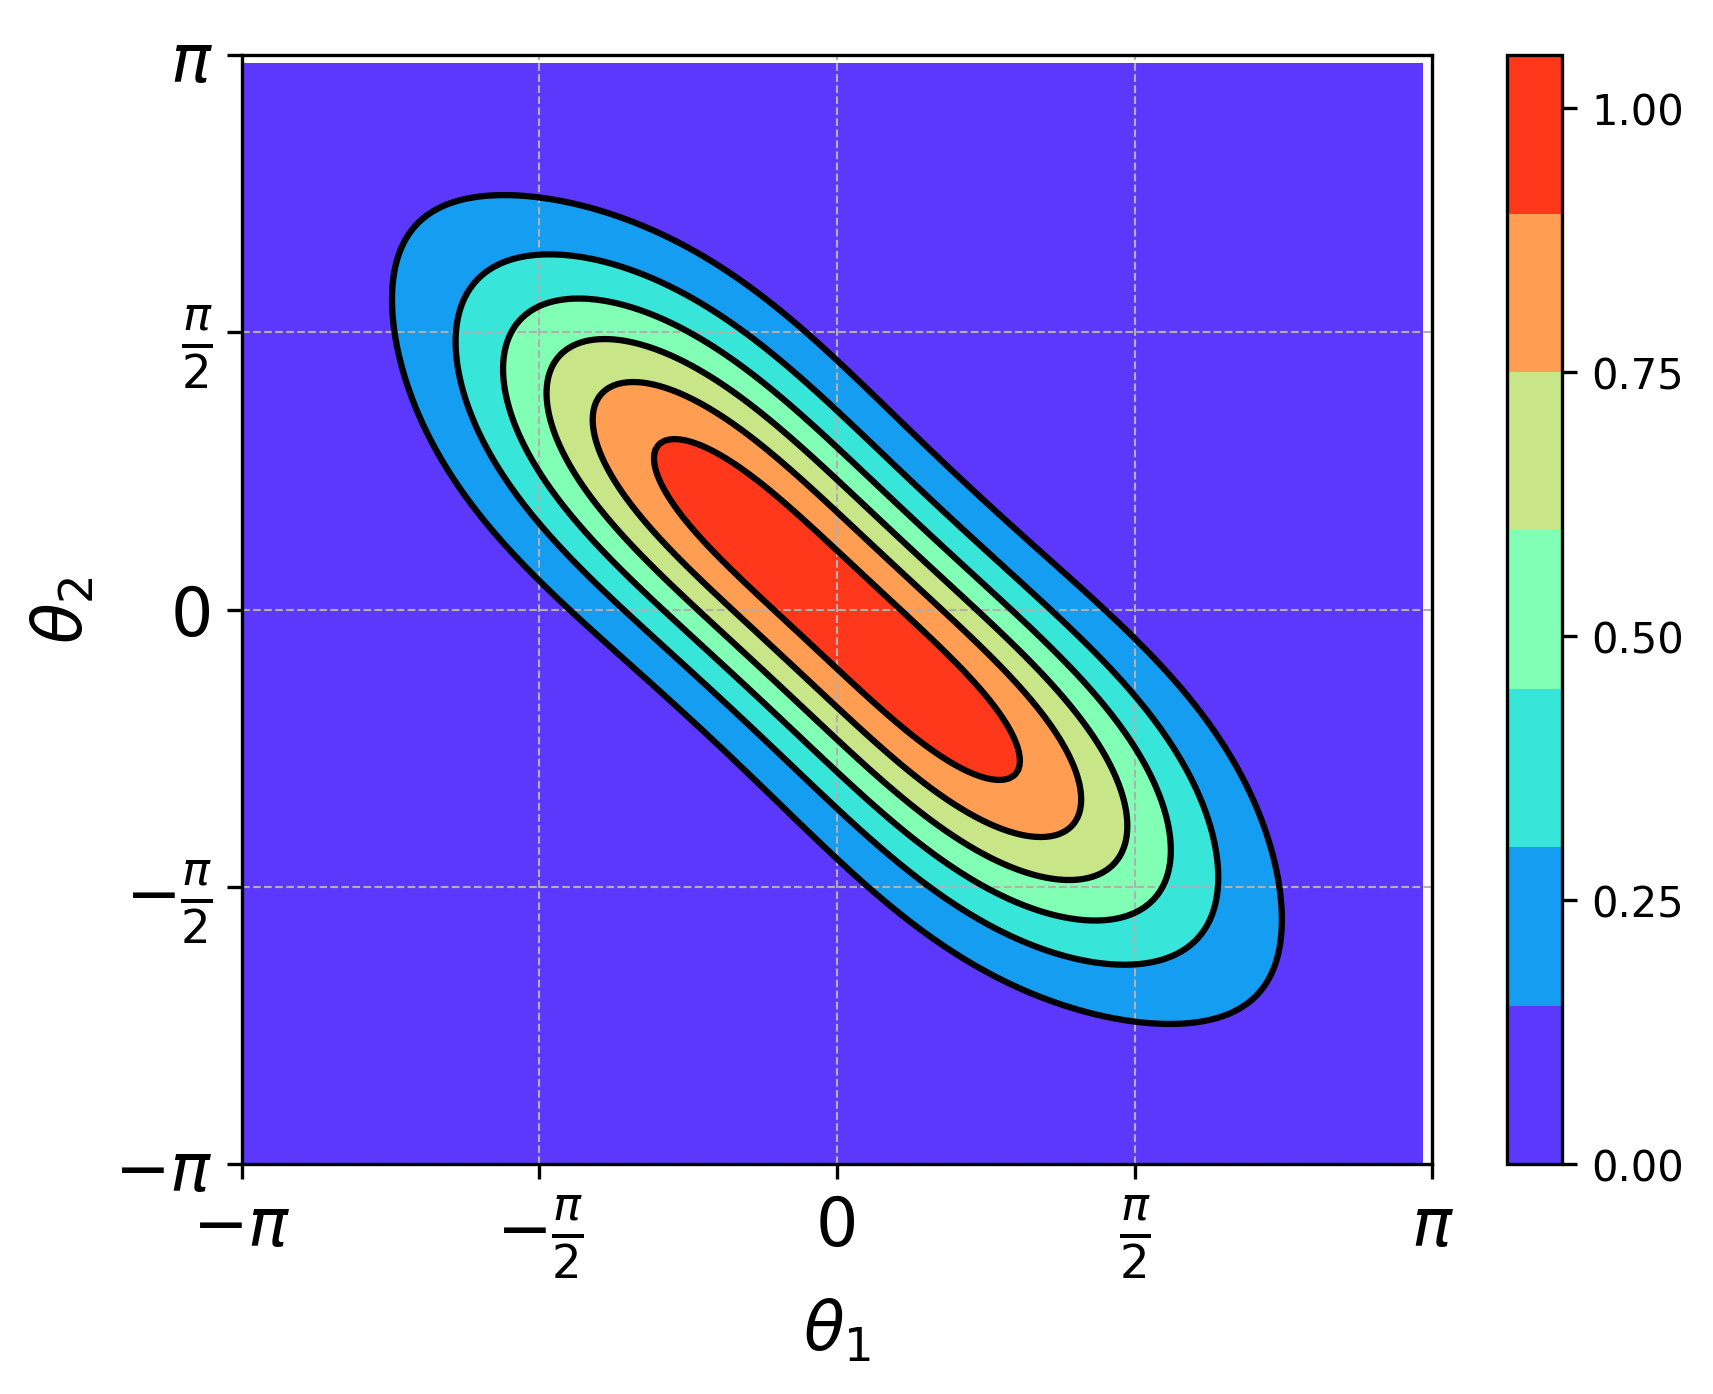

In [7]:
h = 1/(N+1)
p1 = range(-N//2, N//2)
p2 = range(-N//2, N//2)
P1, P2 = np.meshgrid(p1, p2)
theta1 = 2*np.pi*P1*h
theta2 = 2*np.pi*P2*h

Z = abs(Y[0, 0].cpu().detach().numpy())
print(Z.max())
plt.figure(dpi=300)
plt.contour(theta1, theta2, Z, colors='black')
contour = plt.contourf(theta1, theta2, Z, cmap='rainbow')
plt.colorbar(contour, ticks=np.linspace(Z.min(), Z.max(), num=5), format=FormatStrFormatter('%.2f'))

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
            [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
            [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)

plt.xlabel(r'$\theta_1$', fontsize=16)
plt.ylabel(r'$\theta_2$', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.show()
# plt.savefig("image/ani_lfa.png", dpi=300, bbox_inches="tight")